In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2



In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d mahmoudreda55/satellite-image-classification

Dataset URL: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification
License(s): copyright-authors
 78% 17.0M/21.8M [00:00<00:00, 38.2MB/s]
100% 21.8M/21.8M [00:00<00:00, 43.8MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/satellite-image-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import os
import cv2

# Define the path to the data folder
data_folder = '/content/data'

# Initialize a dictionary to hold the image data
data = {}
labels = []

# Loop through each subdirectory in the data folder
for class_name in os.listdir(data_folder):
    class_path = os.path.join(data_folder, class_name)

    # Ensure we are only reading directories
    if os.path.isdir(class_path):
        data[class_name] = []  # Create a list to store images of the current class
        labels.append(class_name)

        # Loop through each image in the subdirectory
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            # Read the image using OpenCV
            image = cv2.imread(image_path)

            # Ensure the image was successfully read
            if image is not None:
                data[class_name].append(image)

# Print out the number of images per class to verify the data loading
for label in labels:
    print(f"Class '{label}' has {len(data[label])} images.")


Class 'green_area' has 1500 images.
Class 'desert' has 1131 images.
Class 'cloudy' has 1500 images.
Class 'water' has 1500 images.


In [6]:
# Check the data dictionary content before plotting
for label in labels:
    print(f"Class '{label}' has {len(data[label])} images.")


Class 'green_area' has 1500 images.
Class 'desert' has 1131 images.
Class 'cloudy' has 1500 images.
Class 'water' has 1500 images.


#### Check If Images Are Loaded Properly



In [7]:
for label in labels:
    for img in data[label]:
        if img is None:
            print(f"Error: Image in class '{label}' could not be loaded.")


#### Function to plot a few sample images from each class

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to plot a few sample images from each class
def plot_sample_images(data, labels):
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(labels):
        # Display a few images from each class
        images = data[label][:5]  # Display up to 5 images per class
        for j, img in enumerate(images):
            plt.subplot(len(labels), 5, i * 5 + j + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(label)
            plt.axis('off')
    plt.tight_layout()
    plt.show()


#### Plotting Image Size Distribution



In [9]:
# Function to analyze and plot the distribution of image sizes
def analyze_image_sizes(data):
    image_shapes = []
    for label, images in data.items():
        for img in images:
            image_shapes.append(img.shape[:2])  # (height, width)

    # Convert image shapes to numpy array and get unique sizes
    image_shapes = np.array(image_shapes)
    unique_shapes, counts = np.unique(image_shapes, axis=0, return_counts=True)

    # Plot the distribution of image sizes
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(unique_shapes)), counts, tick_label=[f'{h}x{w}' for h, w in unique_shapes])
    plt.xticks(rotation=45)
    plt.xlabel('Image Dimensions (Height x Width)')
    plt.ylabel('Count')
    plt.title('Distribution of Image Sizes')
    plt.show()


#### Color Distribution Analysis

In [10]:
# Function to plot the color distribution for a few sample images
def plot_color_distribution(image):
    colors = ('b', 'g', 'r')
    plt.figure(figsize=(8, 4))
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
    plt.title('Color Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()


In [11]:
import matplotlib.pyplot as plt

# Function to plot the distribution of images per class
def plot_class_distribution(data):
    class_counts = {label: len(images) for label, images in data.items()}

    # Plotting the class distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Images per Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#### Running the EDA

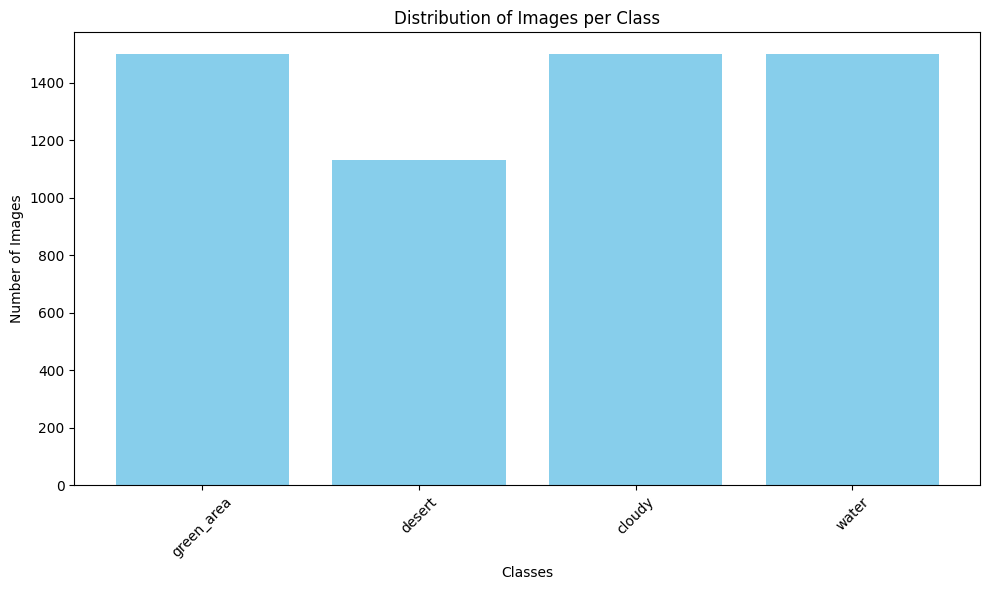

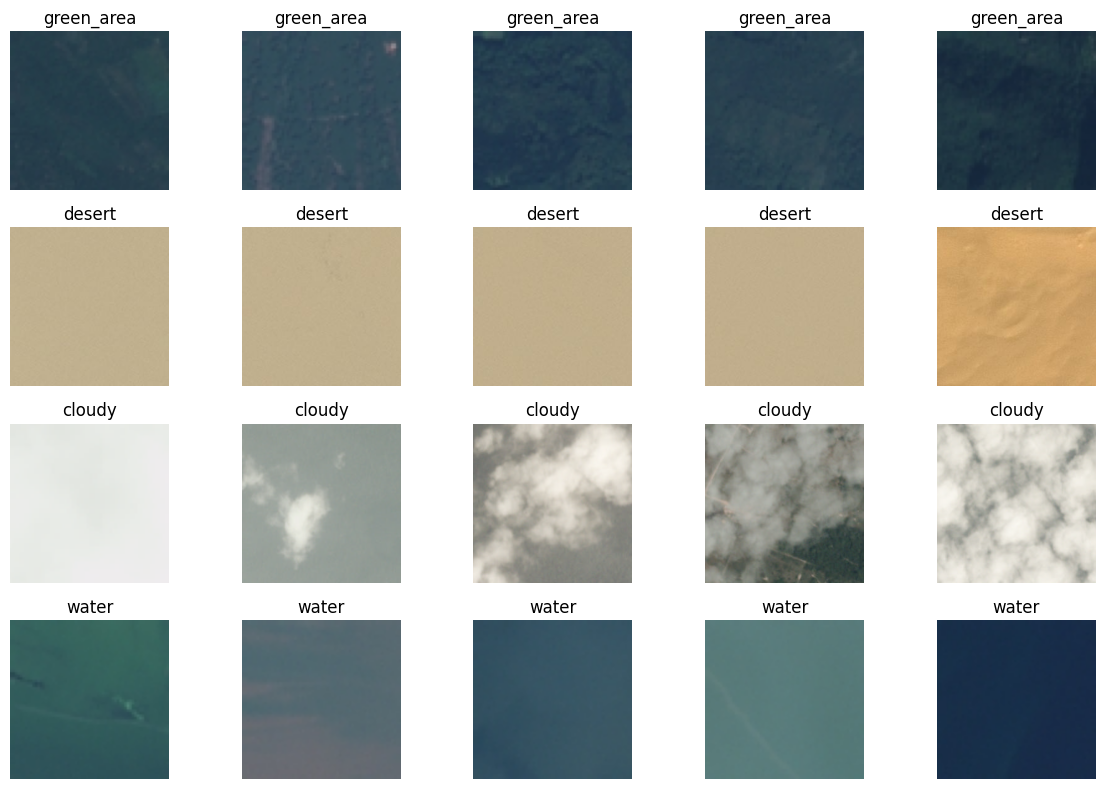

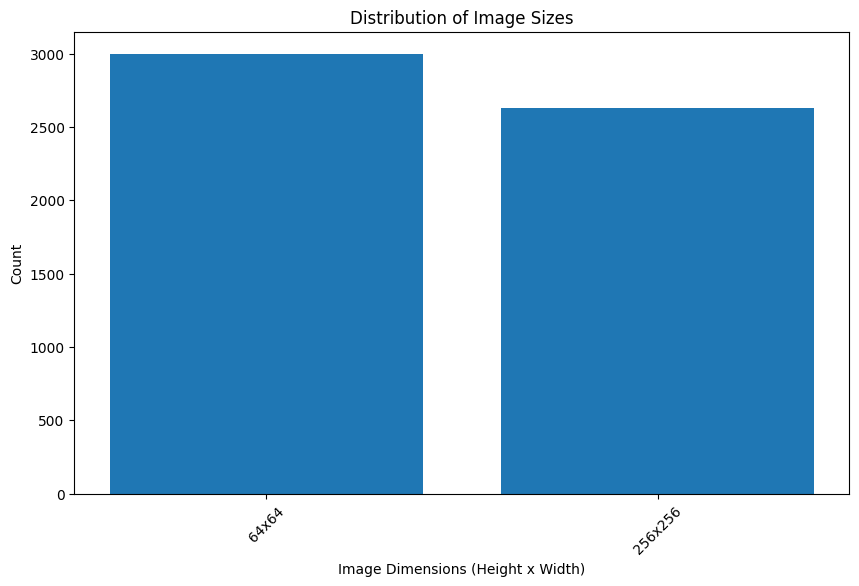

Color distribution for class: green_area


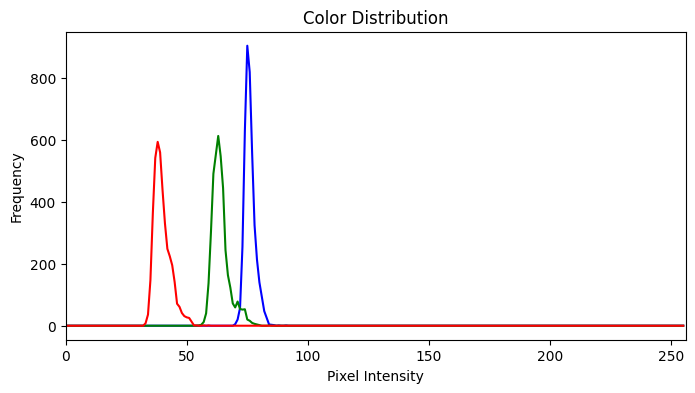

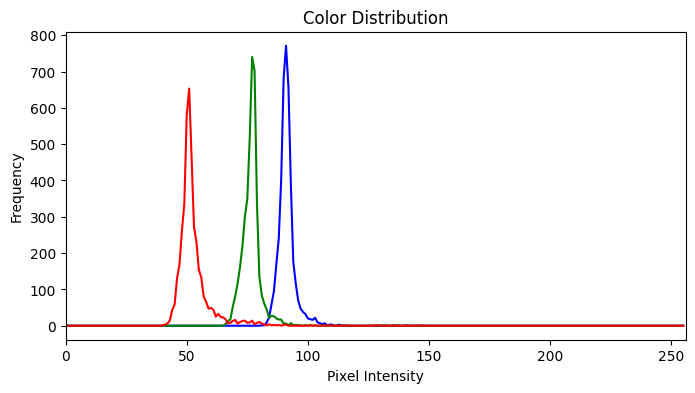

Color distribution for class: desert


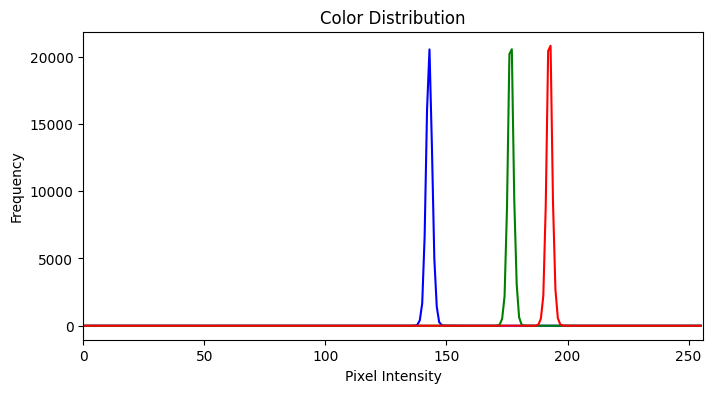

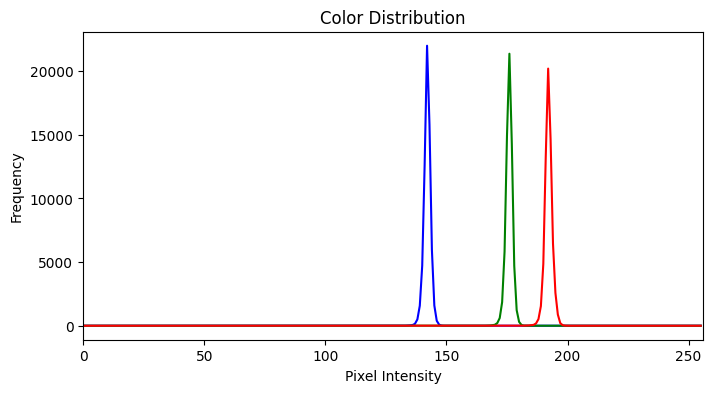

In [12]:
# Define the path to the data folder
data_folder = '/content/data'

# Initialize a dictionary to hold the image data and labels list
data = {}
labels = []

# Load the dataset into a dictionary
for class_name in os.listdir(data_folder):
    class_path = os.path.join(data_folder, class_name)
    if os.path.isdir(class_path):
        data[class_name] = []  # Create a list to store images of the current class
        labels.append(class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = cv2.imread(image_path)
            if image is not None:
                data[class_name].append(image)

# Step 1: Basic info
plot_class_distribution(data)

# Step 2: Plotting sample images
plot_sample_images(data, labels)

# Step 3: Image size distribution analysis
analyze_image_sizes(data)

# Step 4: Color distribution analysis (for a few samples)
for label in labels[:2]:  # Analyzing two sample classes for color distribution
    print(f'Color distribution for class: {label}')
    for img in data[label][:2]:  # Analyzing first two images per class
        plot_color_distribution(img)


#### Training the data model

In [13]:
# Initialize dictionaries to store train, validation, and test data
train_data = {}
val_data = {}
test_data = {}

# Split ratio: 70% train, 15% validation, 15% test
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

for label in labels:
    # Get all images for the current class
    images = data[label]

    # First, split into train and temp (validation + test) sets
    train_images, temp_images = train_test_split(images, test_size=(1 - train_ratio), random_state=42)

    # Then, split the temp set into validation and test sets
    val_images, test_images = train_test_split(temp_images, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

    # Store the splits in the respective dictionaries
    train_data[label] = train_images
    val_data[label] = val_images
    test_data[label] = test_images

# Display the number of images in each split for verification
for label in labels:
    print(f"Class '{label}': {len(train_data[label])} train, {len(val_data[label])} validation, {len(test_data[label])} test images.")


Class 'green_area': 1049 train, 225 validation, 226 test images.
Class 'desert': 791 train, 170 validation, 170 test images.
Class 'cloudy': 1049 train, 225 validation, 226 test images.
Class 'water': 1049 train, 225 validation, 226 test images.


In [14]:
# Set image dimensions
IMG_HEIGHT = 128
IMG_WIDTH = 128

# Function to preprocess images
def preprocess_images(data_dict):
    images = []
    labels = []
    for label, image_list in data_dict.items():
        for img in image_list:
            img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            images.append(img_resized)
            labels.append(label)
    return np.array(images), np.array(labels)

# Preprocess train, validation, and test data
X_train, y_train = preprocess_images(train_data)
X_val, y_val = preprocess_images(val_data)
X_test, y_test = preprocess_images(test_data)

# Normalize the images to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Encode labels into numeric format
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_train = to_categorical(le.fit_transform(y_train))
y_val = to_categorical(le.transform(y_val))
y_test = to_categorical(le.transform(y_test))


#### CNN

In [15]:
# Building the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(labels), activation='softmax')  # Number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the model

In [16]:
# Set up data augmentation to improve the model's generalization
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
datagen.fit(X_train)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=25)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


124/124 ━━━━━━━━━━━━━━━━━━━━ 33s 184ms/step - accuracy: 0.6680 - loss: 0.6541 - val_accuracy: 0.8130 - val_loss: 0.4027
Epoch 2/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 29s 145ms/step - accuracy: 0.8062 - loss: 0.4567 - val_accuracy: 0.8521 - val_loss: 0.3326
Epoch 3/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.8603 - loss: 0.3327 - val_accuracy: 0.8734 - val_loss: 0.3339
Epoch 4/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step - accuracy: 0.8627 - loss: 0.3337 - val_accuracy: 0.8651 - val_loss: 0.3294
Epoch 5/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - accuracy: 0.8796 - loss: 0.3041 - val_accuracy: 0.8367 - val_loss: 0.3396
Epoch 6/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 0.8616 - loss: 0.3380 - val_accuracy: 0.8970 - val_loss: 0.2633
Epoch 7/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - accuracy: 0.8850 - loss: 0.2806 - val_accuracy: 0.7941 - val_loss: 0.6863
Epoch 8/25
124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - accuracy: 0.8520 - loss: 0.4006 - val

#### Evaluting the model on test data

In [17]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc * 100:.2f}%")


27/27 - 1s - 36ms/step - accuracy: 0.9104 - loss: 0.2311
Test accuracy: 91.04%


import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


#### Visualizing training result

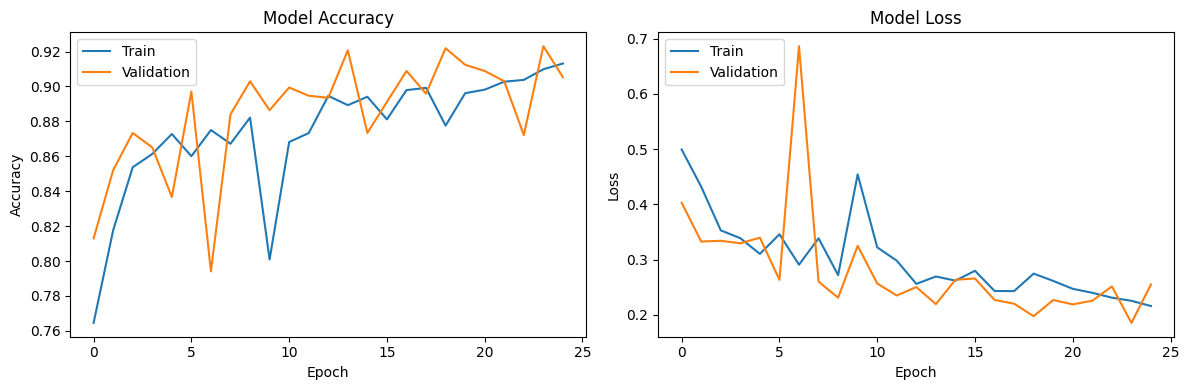

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


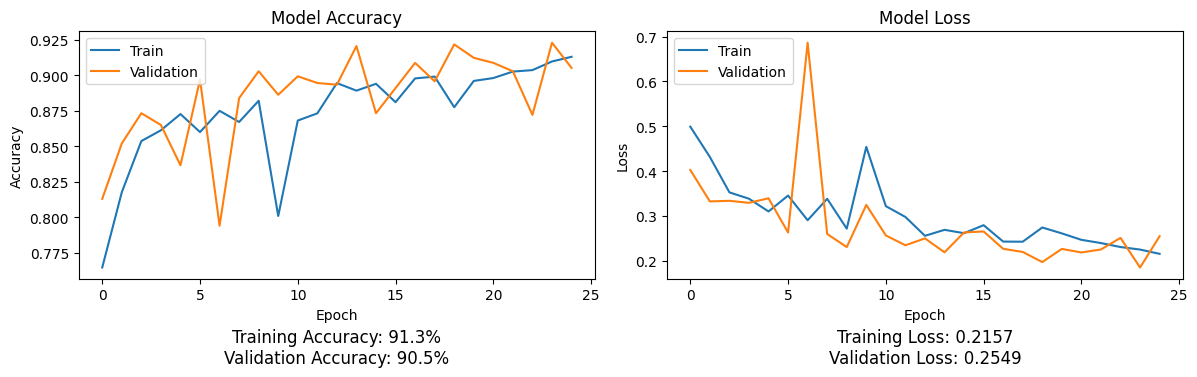

In [19]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Get the last training and validation accuracy
train_accuracy = history.history['accuracy'][-1] * 100  # Convert to percentage
val_accuracy = history.history['val_accuracy'][-1] * 100  # Convert to percentage
plt.text(0.5, -0.2, f'Training Accuracy: {train_accuracy:.1f}%\nValidation Accuracy: {val_accuracy:.1f}%',
         ha='center', va='top', fontsize=12, transform=plt.gca().transAxes)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Get the last training and validation loss
train_loss = history.history['loss'][-1]  # Last training loss
val_loss = history.history['val_loss'][-1]  # Last validation loss
plt.text(0.5, -0.2, f'Training Loss: {train_loss:.4f}\nValidation Loss: {val_loss:.4f}',
         ha='center', va='top', fontsize=12, transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()


In [20]:
model.save('satellite_image_classification_model.h5')